# Heatmap of avg. probability vs. class and time

For one classifier and one true class (and then looping over them!), show the average probability assigned to each class for objects of that true class as a function of time.

Hack note: because this is based on a histogram in a database materialized view, there's an issue with the lowest probability bin.  See "HACK ALERT" in the cell below that actually does the plots.

In [1]:
%matplotlib inline
import sys
import os
import requests
import datetime
import dateutil.parser
import logging
import json
import numpy
import pandas
import matplotlib
from matplotlib import pyplot
import seaborn
import sklearn
import sklearn.metrics

from metric_querier import ELAsTiCCMetricsQuerier

In [2]:
logger = logging.getLogger(__name__)
if not logger.hasHandlers():
    _logout = logging.StreamHandler( sys.stderr )
    logger.addHandler( _logout )
    _formatter = logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s', datefmt='%Y-%m-%d %H:%M:%S' )
    _logout.setFormatter( _formatter )

logger.setLevel( logging.DEBUG )

In [3]:
username = "rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_"+username+"_passwd" ) ) as ifp:
    password = ifp.readline().strip()
    
emq = ELAsTiCCMetricsQuerier( tomusername=username, tompasswd=password, logger=logger )

In [4]:
# Run help(ELAsTiCCMetricsQuerier) for lots of information
probhist = emq.probhist()

[2023-03-13 10:38:29 - DEBUG] - Sending query to get probabilistic metrics histogram table
[2023-03-13 10:38:41 - DEBUG] - Got response, pandifying
[2023-03-13 10:38:43 - DEBUG] - Done


In [5]:
probhist

count
classifierId trueClassId classId tbin probbin       
36           111         0       1    21           4
                                 2    21         133
                                 3    21        2217
                                 4    21        3333
                                 5    21        2887
...                                              ...
89           221         135     27   16        1524
                                      17        1464
                                      18        1669
                                      19        1412
                                      20        1327

[1226274 rows x 1 columns]

In [6]:
# cferstodo = list( emq.classifier_info.keys() )
cferstodo = [ 40, 89, 44 ]
# cferstodo = [ 40 ]
trueclasstodo = [ 111, 112, 113, 131 ]
# trueclasstodo = [ 111 ]
print( f"Going to do classifiers: {cferstodo}" )
print( f"Going to do classes: {[emq.classname[i] for i in trueclasstodo]}" )

Going to do classifiers: [40, 89, 44]
Going to do classes: ['Ia', 'Ib/c', 'II', 'SLSN']


[2023-03-13 10:38:43 - DEBUG] - doing cfer 40, true class Ia
[2023-03-13 10:38:44 - DEBUG] - doing cfer 40, true class Ib/c
[2023-03-13 10:38:44 - DEBUG] - doing cfer 40, true class II
[2023-03-13 10:38:45 - DEBUG] - doing cfer 40, true class SLSN
[2023-03-13 10:38:45 - DEBUG] - doing cfer 89, true class Ia
[2023-03-13 10:38:45 - DEBUG] - doing cfer 89, true class Ib/c
[2023-03-13 10:38:46 - DEBUG] - doing cfer 89, true class II
[2023-03-13 10:38:46 - DEBUG] - doing cfer 89, true class SLSN
[2023-03-13 10:38:46 - DEBUG] - doing cfer 44, true class Ia
[2023-03-13 10:38:47 - DEBUG] - doing cfer 44, true class Ib/c
[2023-03-13 10:38:47 - DEBUG] - doing cfer 44, true class II
[2023-03-13 10:38:47 - DEBUG] - doing cfer 44, true class SLSN


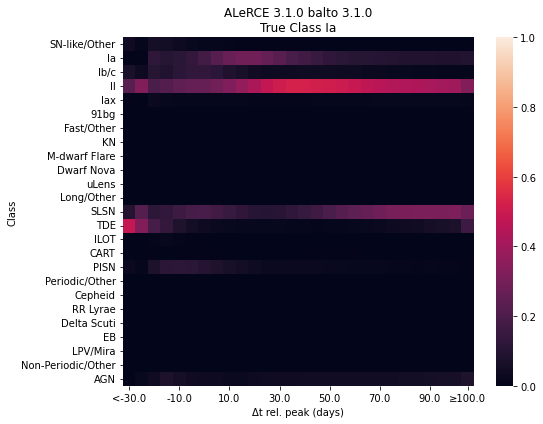

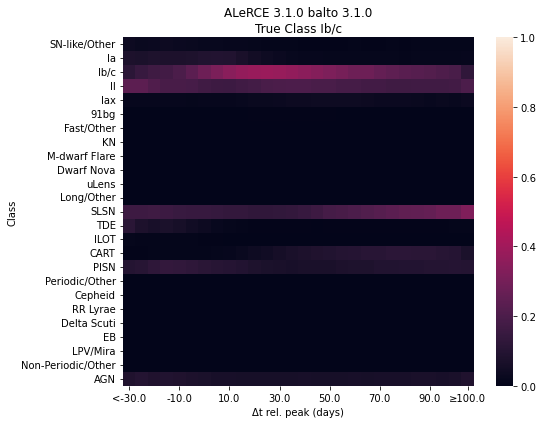

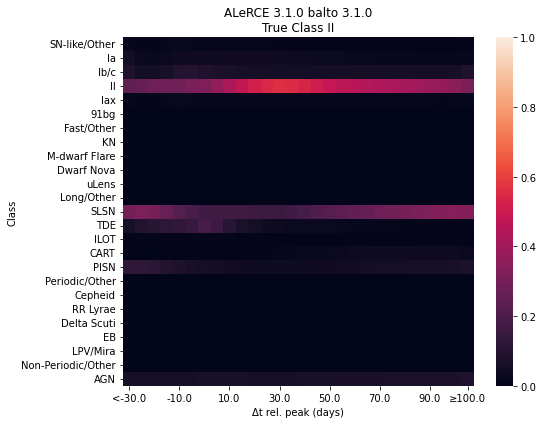

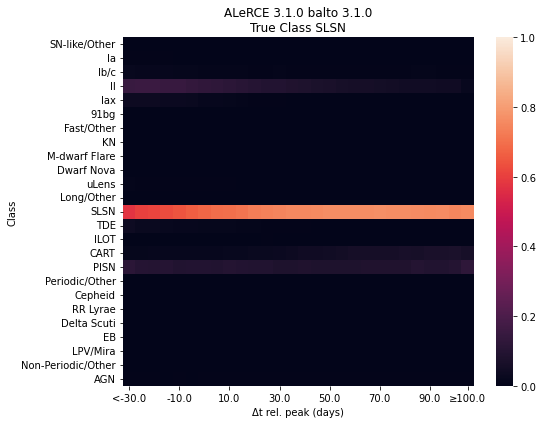

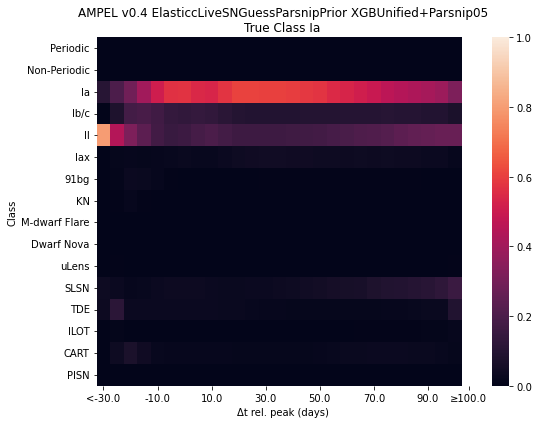

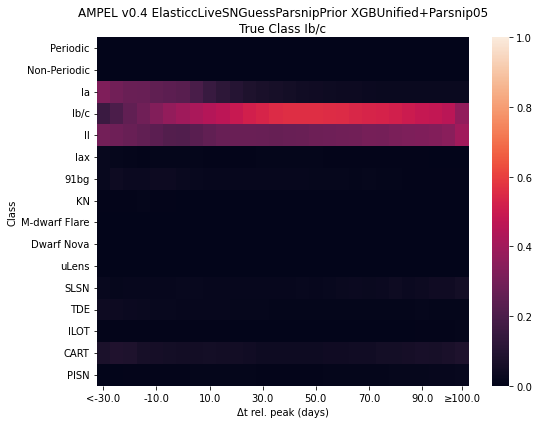

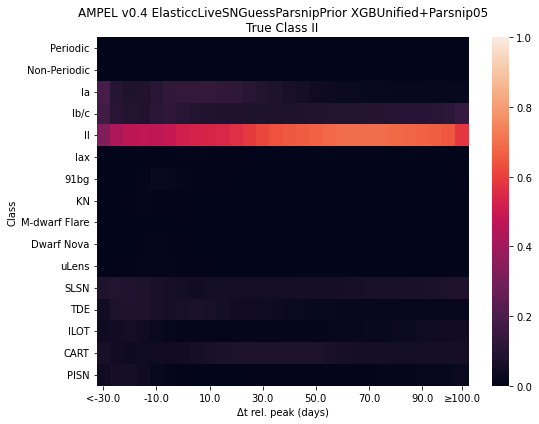

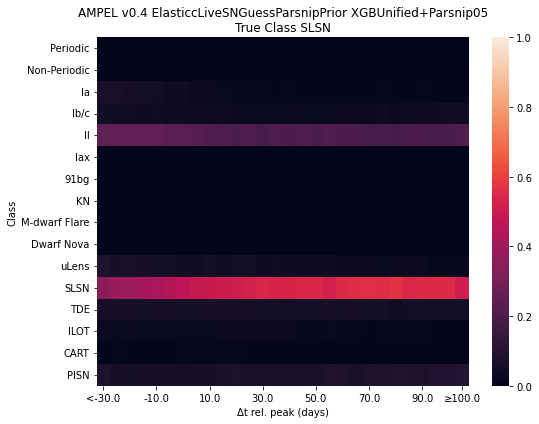

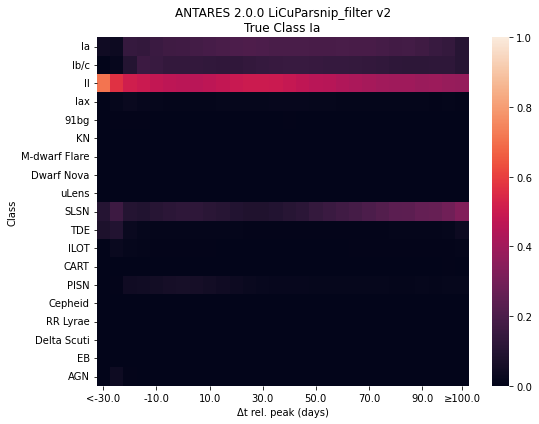

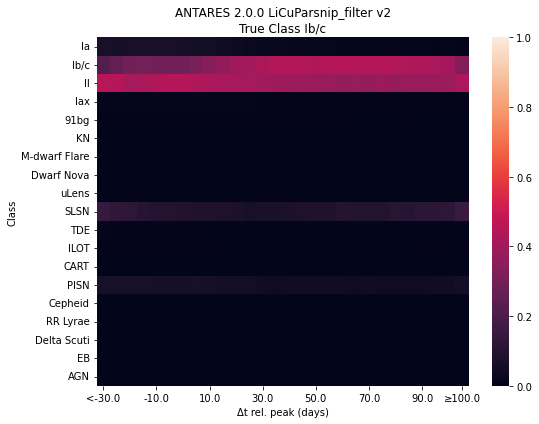

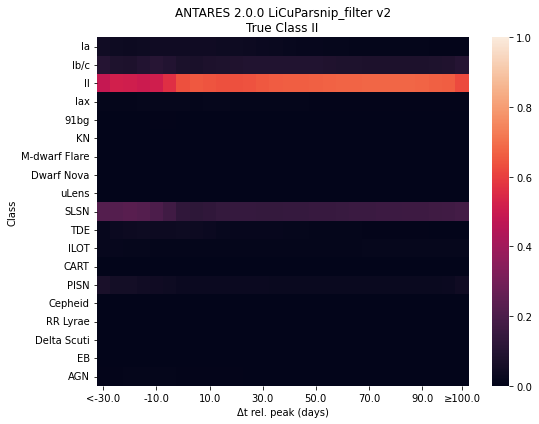

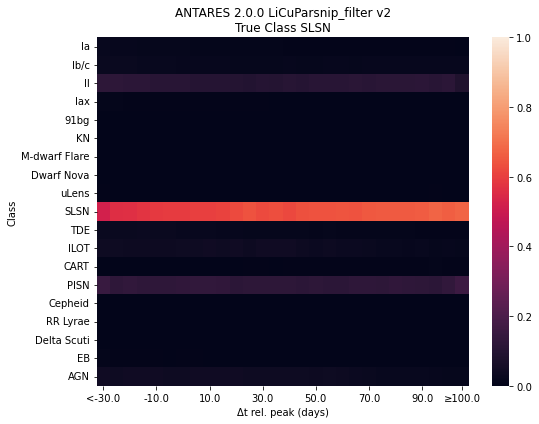

In [7]:
for cfer in cferstodo:
    brokername = emq.classifier_info[cfer]['brokerName']
    brokerversion = emq.classifier_info[cfer]['brokerVersion']
    classifiername = emq.classifier_info[cfer]['classifierName']
    classifierparams = emq.classifier_info[cfer]['classifierParams']
    cfertitle = f'{brokername} {brokerversion} {classifiername} {classifierparams}'
    for trueclass in trueclasstodo:
        logger.debug( f"doing cfer {cfer}, true class {emq.classname[trueclass]}" )
        title = f"True Class {emq.classname[trueclass]} for {cfertitle}"
        subdf = probhist.xs( ( cfer, trueclass ), level=( 'classifierId', 'trueClassId' ) )
        probdf = subdf / subdf.groupby( ['classId', 'tbin'] ).sum()
        probdf.reset_index( inplace=True )
        probdf.set_index( ['tbin', 'probbin', 'classId'], inplace=True )
        # logger.debug( f"Before filling in missing indexes, len(probhist) = {len(probhist)}" )
        # Fill in missing indexes with 0s.  This is a bit slow (takes a couple of seconds each time).
        # new_indices = pandas.MultiIndex.from_product( [ range( 0, emq.tbin_num+2 ), range( 0, emq.probbin_num+2 ), 
        #                                                 probdf.index.get_level_values('classId') ] )
        # probdf.reindex( new_indices, fill_value=0. )
        # logger.debug( f"After filling in missing indexes, len(probhist) = {len(probhist)}" )
        # Fill in the probability values associated with the bins
        probdf['prob'] = emq.probbin_val( probdf.reset_index()['probbin'] )
        # HACK ALERT.  There's this issue with the histogramming.  Probably (but not certainly) lots
        # of the things that show up in probbin=1 are really 0 probabilities reported by the brokers,
        # but now that we've binned it we're going to treat it as 0.025.  Big deal, you say, until
        # you realize that there might be 15 classes that all were given 0 probability by a
        # broker, and now you've got an extra 15*0.025=0.625 of probability that's not real!  So, 
        # we're going to make the rash assumption that the probability value associated with 
        # probbin=1 is 0, not 2.5%, which is wrong, but hopefully less wrong than a direct
        # interpretation of the histogram.
        probdf.loc[ pandas.IndexSlice[ :, 1, : ] ] = 0.
        # Don't need probbin any more
        probdf.reset_index( inplace=True )
        probdf.drop( [ 'probbin' ] , axis=1, inplace=True )
        probdf.set_index( [ 'tbin', 'classId' ], inplace=True )
        
        # Finally, combine things together to get a total probability
        #   as a function of classId and tbin
        probdf['prob'] *= probdf['count']
        probdf.drop( [ 'count' ], axis=1, inplace=True )
        probdf = probdf.groupby( [ 'tbin', 'classId' ] ).apply( sum )

        # To check how much probability we've lost with our assuming probbin1 is 0 probability,
        # do probdf.groupby(['tbin']).sum()

        # Fill in the missing tbins
        # logger.debug( f"Before fliling in missing tbins, len(probdf) = {len(probdf)}" )
        new_indices = pandas.MultiIndex.from_product( [ range(0, emq.tbin_num+2), probdf.index.get_level_values( 'classId' ) ] )
        probdf.reindex( new_indices, fill_value=0. )
        # logger.debug( f"After filling in missing tbins, len(probdf) = {len(probdf)}" )
        
        # Finally, we're ready to plot
        
        fig = pyplot.figure( figsize=(8,6), tight_layout=True )
        ax = fig.add_subplot( 1, 1, 1 )
        pt = pandas.pivot_table( probdf, values="prob", columns="tbin", index="classId" )
        seaborn.heatmap( pt, vmin=0, vmax=1 )
        xticks = numpy.arange( 0, emq.tbin_num+2, 4 ) + 0.5
        # ensure that the highest bin is included
        if xticks[-1] != emq.tbin_num+1:
            xticks = numpy.append( xticks, emq.tbin_num+1.5 )
        # xticklabs = [ str(emq.tbin_val(int(i.get_text()))) for i in ax.get_xticklabels() ]
        xticklabs = [ str(i) for i in emq.tbin_val(xticks) ]
        xticklabs[0] = f"<{emq.tbin_min}"
        xticklabs[-1] = f"≥{emq.tbin_max}"
        ax.set_xticks( xticks )
        ax.set_xticklabels( xticklabs ) 
        ax.set_yticklabels( [ emq.classname[ int(i.get_text()) ] for i in ax.get_yticklabels() ], rotation=0 )
        ax.set_xlabel( "Δt rel. peak (days)" )
        ax.set_ylabel( "Class" )
        ax.set_title( f"{cfertitle}\nTrue Class {emq.classname[trueclass]}" )
        fig.show()
        